In [1]:
import os
import numpy as np

from PIL import Image, ImageChops
import operator
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pickle as pk

## Train ML model

In [3]:
train_path = 'dataset'
l = []

for subpath in tqdm(os.listdir(train_path)):
    for file in os.listdir(train_path+'/'+subpath):
        path = train_path+'/'+subpath+'/'+file
        im = Image.open(path)
        im_arr = (np.array(ImageChops.invert(Image.open(path)).resize((28,28)))/255).flatten()
        im_arr = np.append(im_arr, int(subpath))
        l.append(im_arr)

dataset = pd.DataFrame(l)
dataset = dataset.rename(columns={784:'label'})
dataset.to_csv('dataset.csv',index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.24s/it]


In [2]:
dataset = pd.read_csv('dataset.csv')
X = np.array(dataset.drop('label',axis=1))
y = np.array(dataset.label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('training set population',Counter(y_train))

training set population Counter({5.0: 826, 9.0: 820, 7.0: 818, 8.0: 816, 2.0: 816, 4.0: 815, 6.0: 813, 1.0: 810, 3.0: 799, 0.0: 795})


In [3]:
%%time

# cross-validator : Stratified Shuffle Split 
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42) 

# Functions to be used in the pipeline
skb = SelectKBest(f_classif)

### Define classifier ###
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ('SKB',skb),
    ('LDA',clf)
])   

# parameters to tune 
param_grid = {
    'SKB__k':['all'],
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

# training classifier
print (" > training classifier on training set:")
grid.fit(X_train, y_train)

# best classifier using the cross-validator and the Stratified Shuffle Split 
clf = grid.best_estimator_

# predicition with the classifier
print (" > testing classifier on testing set:")
y_pred = clf.predict(X_test)

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)
print(classification_report(y_test, y_pred))

 > training classifier on training set:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.7s finished


 > testing classifier on testing set:

 > Best grid search:
{'SKB__k': 'all'}
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       221
         1.0       0.99      1.00      0.99       206
         2.0       0.98      0.99      0.99       200
         3.0       0.99      0.99      0.99       217
         4.0       0.99      0.99      0.99       201
         5.0       0.99      0.98      0.99       190
         6.0       0.99      0.98      0.98       203
         7.0       0.99      0.99      0.99       198
         8.0       0.99      0.98      0.99       200
         9.0       0.99      0.97      0.98       196

    accuracy                           0.99      2032
   macro avg       0.99      0.99      0.99      2032
weighted avg       0.99      0.99      0.99      2032

Wall time: 42.8 s


NameError: name 'confusion_matrix' is not defined

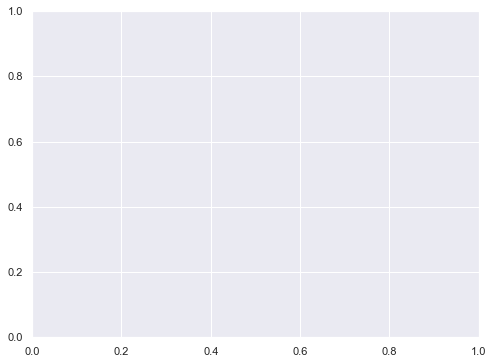

In [4]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    cmap='YlGnBu', 
    linewidths=.2,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    fmt='d'
)

In [ ]:
# dump classifier in a pickle file
print ("\n > Classifier dumped")
with open("digit_classifier.pkl", 'wb') as fid:
    pk.dump(clf, fid)